**Setup for visualizers**

The notebook loads a cohort of patients with mutations in *SUOX*, performs the functional variant annotation, and collates the data into a `Cohort` object.

In [1]:
%matplotlib inline

import os
import hpotk

hpotk.util.setup_logging()

# Setup resources


## Load HPO

Use HPO release *2023-10-09*. The ontology is downloaded from the PURL.

> Note: feel free to download the file once and provide the local path, e.g. `/home/joe/path/to/hp.json`.

In [2]:
fpath_hpo = 'https://github.com/obophenotype/human-phenotype-ontology/releases/download/v2023-10-09/hp.json'

hpo = hpotk.load_minimal_ontology(fpath_hpo)
hpo.version

'2023-10-09'

# Load samples

## Configure patient creator

Patient creator transforms phenopackets into `Patient`s - the internal representation of the sample data. 

The transformation includes checking that the phenotypic features -  the uses HPO to check all phenotypic features are annotated with current HPO terms 

### Setup phenotypic feature validation

We ensure that the phenotypic features of the subjects meet the following validation requirements:
- the phenotypic features are represented using current (non-obsolete) HPO term IDs
- all phenotypic features are descendants of *Phenotypic abnormality* branch of HPO
- the terms do not violate the annotation propagation rule - subjects are not annotated by a term and its ancestor/descendant

In [3]:
from hpotk.validate import ValidationRunner
from hpotk.validate import ObsoleteTermIdsValidator, PhenotypicAbnormalityValidator, AnnotationPropagationValidator

validation_runner = ValidationRunner(
    validators=(
        ObsoleteTermIdsValidator(hpo),
        PhenotypicAbnormalityValidator(hpo),
        AnnotationPropagationValidator(hpo)
        ))

In [4]:
from genophenocorr.preprocessing import configure_caching_patient_creator

pc = configure_caching_patient_creator(hpo, validation_runner=validation_runner)

## Load phenopackets

Walk the directory, find all JSON files, load them into phenopackets, and transform the phenopackets to patients.

> Note: the first run takes longer since we must reach out to VEP REST API. However, the subsequent runs use data that we cache in `.genophenocorr_cache` folder next to this notebook.

In [5]:
from genophenocorr.preprocessing import load_phenopacket_folder

fpath_suox_cohort = os.path.join(os.getcwd(), os.pardir, 'notebooks', 'SUOX', 'phenopackets')
cohort = load_phenopacket_folder(fpath_suox_cohort, pc)
f'Loaded {len(cohort)} samples'

Patients Created: 100%|██████████| 35/35 [00:00<00:00, 340.95it/s]


'Loaded 35 samples'

# Gather data for visualization

Here we get the data required for visualizing the variants on selected transcript or protein.

## Choose the transcript

We need to choose the transcript and protein IDs - currently this is done manually but we will find a way how to do this automatically, e.g. using MANE transcript.

The MANE Select transcript for *SUOX* is [NM_001032386.2](https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:11460) and the corresponding protein accession ID is `NP_001027558.1`.

In [6]:
tx_id = 'NM_001032386.2'
protein_id = 'NP_001027558.1'

## Gather the data for visualization

We need to get:
- variants
- transcript coordinates
- protein metadata

### Variants

Variants are easy, `Cohort` exposes all the variants via the `all_variants` property:

In [7]:
variants = cohort.all_variants
len(variants)

48

In [8]:
next(iter(variants))

Variant(variant_coordinates:VariantCoordinates(region=GenomicRegion(contig=12, start=56004514, end=56004515, strand=+), ref=C, alt=T, change_length=1), tx_annotations:(TranscriptAnnotation(gene_id:SUOX,transcript_id:NM_000456.3,hgvsc_id:NM_000456.3:c.1126C>T,is_preferred:False,variant_effects:(<VariantEffect.MISSENSE_VARIANT: 'SO:0001583'>,),overlapping_exons:(6,),protein_affected:(ProteinMetadata(id=NP_000447.2, label=Sulfite oxidase, mitochondrial, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Cytochrome b5 heme-binding, start=82, end=161)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Hinge, start=165, end=174)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Moco domain, start=175, end=401)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Homodimerization, start=402, end=538)))),),protein_effect_location:Region(start=375, end=376)), TranscriptAnnotation(gene_id:SUOX,transcript_id:NM_001

### Transcript coordinates

Transcript coordinates can be fetched from Variant Validator API:

In [9]:
from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService

txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(tx_id)
tx_coordinates

TranscriptCoordinates(identifier=NM_001032386.2, region=GenomicRegion(contig=12, start=55997275, end=56005525, strand=+))

The `TranscriptCoordinates` object knows about the number of coding bases and aminoacid codons. 

Note, the counts of coding bases and codons do *not* include the termination codon.

In [10]:
print(f'{tx_id} has {tx_coordinates.get_coding_base_count():,} coding bases')
print(f'{tx_id} has {tx_coordinates.get_codon_count():,} codons')

NM_001032386.2 has 1,635 coding bases
NM_001032386.2 has 545 codons


We can get the UTR regions (both 5' and 3') as well as the CDS regions.

Note, for simplicity, the CDS regions include *both* initiation and termination codons!

5' UTR regions:

In [11]:
for utr in tx_coordinates.get_five_prime_utrs():
    print(f'{utr.start:,}-{utr.end:,}')

55,997,275-55,997,339
55,997,614-55,997,723
56,002,211-56,002,221


CDS regions:

In [12]:
for cds in tx_coordinates.get_cds_regions():
    print(f'{cds.start:,}-{cds.end:,}')

56,002,221-56,002,271
56,002,542-56,002,720
56,003,617-56,005,027


3' UTR regions

In [13]:
for utr in tx_coordinates.get_three_prime_utrs():
    print(f'{utr.start:,}-{utr.end:,}')

56,005,027-56,005,525


### Protein metadata

Last, we fetch the protein metadata from Uniprot.

The significance of the warning that is logged is unclear to me at this time. We need to investigate.

In [14]:
from genophenocorr.preprocessing import UniprotProteinMetadataService

pms = UniprotProteinMetadataService()

protein_metas = pms.annotate(protein_id)

assert len(protein_metas) == 1
protein_meta = protein_metas[0]
protein_meta

ProteinMetadata(id=NP_001027558.1, label=Sulfite oxidase, mitochondrial, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Cytochrome b5 heme-binding, start=82, end=161)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Hinge, start=165, end=174)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Moco domain, start=175, end=401)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Homodimerization, start=402, end=538))))

We get metadata with 4 features (1 domain and 3 regions), which is in line with the Uniprot [Family & Domains section](https://www.uniprot.org/uniprotkb/P51687/entry#family_and_domains).

In [15]:
for feature in protein_meta.protein_features:
    print(f'name: {feature.info.name}, type: {feature.feature_type}, start: {feature.info.start}, end: {feature.info.end}, ')

name: Cytochrome b5 heme-binding, type: FeatureType.DOMAIN, start: 82, end: 161, 
name: Hinge, type: FeatureType.REGION, start: 165, end: 174, 
name: Moco domain, type: FeatureType.REGION, start: 175, end: 401, 
name: Homodimerization, type: FeatureType.REGION, start: 402, end: 538, 


# Variant transcript protein figure

## Background

*Gene* is a genomic region that has some functional relevance. Usually, this is because the region includes DNA sequence that encodes a protein product. The information for protein synthesis is encoded in the sequence of DNA nucleotides, one of four letters of the DNA alphabet: `A`, `C`, `G`, `T`. Per [central dogma of molecular biology](https://en.wikipedia.org/wiki/Central_dogma_of_molecular_biology), the information flows from gene to protein. Gene is first transcribed into precursor messenger RNA (pre-mRNA), pre-mRNA undergoes splicing to remove non-coding regions *introns*, resulting in mature messenger RNA (mRNA) that (mostly) consists of coding *exons*. 

However, splicing is not deterministic, and due to several reasons, it can produce several versions of mRNA from one pre-mRNA sequence that encode different protein isoforms. We denote the alternate mRNA versions as *transcripts*, and, depending on splicing, one gene can produce `1..m` transcripts.

After splicing, the sequence of the mature mRNA is translated into a protein sequence. The protein alphabet includes 21 letters - aminoacids the maping between DNA and protein alphabets is dictated by the [codon table](https://en.wikipedia.org/wiki/DNA_and_RNA_codon_tables) (just for reference, no need to study deeper) where *codon* is a triplet of DNA letters that correspond to one protein letter.

There is one more detail left to discuss. The mRNA includes two *untranslated regions* (UTRs), one UTR on each end of mRNA molecule. The UTR at the start is denoted as 5' (read five prime) and the UTR at the end is called 3' (three prime). The UTRs do not encode protein sequence, so, we do not want to plot them.

So, that's about it for background. Now, let me show how to get the information from our domain model.

## Transcript

In our domain model, we ask the user to choose the desired transcript by providing transcript ID:

In [16]:
tx_id

'NM_001032386.2'

Thanks to the ID, our app can fetch the "anatomy" of the transcript - the coordinates of exon regions. The coordinates were fetched above so I'll only reuse `tx_coordinates` here:

In [17]:
print('Start\tEnd\tLength')
for exon in tx_coordinates.exons:
    print(f'{exon.start:,}\t{exon.end:,}\t{len(exon)}')

Start	End	Length
55,997,275	55,997,339	64
55,997,614	55,997,723	109
56,002,211	56,002,271	60
56,002,542	56,002,720	178
56,003,617	56,005,525	1908


We get an instance of `TranscriptCoordinates` that has `exons` property. The property provides a sequence of `genophenocorr.model.genome.GenomicRegion`s that correspond to exon regions.

This transcript has 5 exons. Note that the exons are *not* consecutive - they are separated by introns (not in the model). The exons consist of the coding sequence regions (CDS) and UTRs.

We can get the CDS regions by calling `get_cds_regions()`:

In [18]:
print('Start\tEnd\tLength')
for cds in tx_coordinates.get_cds_regions():
    print(f'{cds.start:,}\t{cds.end:,}\t{len(cds)}')

Start	End	Length
56,002,221	56,002,271	50
56,002,542	56,002,720	178
56,003,617	56,005,027	1410


Same as above, we iterate through `GenomicRegion`s, but they correspond to CDS this time. Note that only 3 exons of this transcript include coding sequence. The entire first 2 exons plus the first 10 bases of the 3rd exon represent the 5'UTR. The 3'UTR spans the last 498 bases (`56,005,525 - 56,005,027 = 498`).

Note that the sum of CDS lengths is always be divisible by 3:

In [19]:
assert sum(len(cds) for cds in tx_coordinates.get_cds_regions()) % 3 == 0, "CDS must be divisible by 3!"

The sum divided by 3 corresponds to the codon count. The last codon ([stop codon](https://en.wikipedia.org/wiki/Stop_codon)) does not encode an aminoacid. Therefore, we can calculate the number of codons that encode the protein aminoacids `aa_count` as follows:

In [20]:
codon_count = sum(len(cds) for cds in tx_coordinates.get_cds_regions()) / 3
aa_count = codon_count - 1
aa_count

545.0

The transcript encodes a protein that consists of 545 aminoacids.

You don't have to compute these by hand, `TxCoordinates` provides some convenience here:

In [21]:
print('N coding bases:', tx_coordinates.get_coding_base_count())
print('N coding codons (aminoacids):', tx_coordinates.get_codon_count())

N coding bases: 1635
N coding codons (aminoacids): 545


## Protein

Let's discuss the protein features.

Genophenocorr knows that `NM_001032386.2` transcript corresponds to `NP_001027558.1` protein and it can fetch the corresponding metadata:

In [22]:
print('Protein ID:', protein_id)
protein_meta

Protein ID: NP_001027558.1


ProteinMetadata(id=NP_001027558.1, label=Sulfite oxidase, mitochondrial, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Cytochrome b5 heme-binding, start=82, end=161)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Hinge, start=165, end=174)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Moco domain, start=175, end=401)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Homodimerization, start=402, end=538))))

`genophenocorr.model.ProteinMetadata` knows about the protein anatomy.

The protein has an identifier and a human-readable label.

In [23]:
print(protein_meta.protein_id)
print(protein_meta.label)

NP_001027558.1
Sulfite oxidase, mitochondrial


The protein metadata includes features - protein regions that were annotated with some useful information.

All features know about their location within the aminoacid sequence. There is `info` property that exposes `region` property. 
The `region` has `start` and `end` that denote the coordinates of the aminoacids spanned by the feature:

In [24]:
print('Name', 'Start', 'End', 'Length', sep='\t')
for pm in protein_meta.protein_features:
    info = pm.info
    region = info.region
    print(info.name, region.start, region.end, len(region), sep='\t')

Name	Start	End	Length
Cytochrome b5 heme-binding	82	161	79
Hinge	165	174	9
Moco domain	175	401	226
Homodimerization	402	538	136


In addition, the features can be of different types. Our data model includes protein *repeats*, *motifs*, *domains*, protein *regions* (see `FeatureType` enum). Not all proteins have been assigned with all feature types, and here we only have domains and regions.

In [25]:
protein_meta.protein_features

(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Cytochrome b5 heme-binding, start=82, end=161)),
 SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Hinge, start=165, end=174)),
 SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Moco domain, start=175, end=401)),
 SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Homodimerization, start=402, end=538)))

So, that's it for the background. Now, let's return to the figure.

## The figure

Let's discuss the requirements of the variant transcript protein figure. I'll use your initial figure from the issue as a reference:

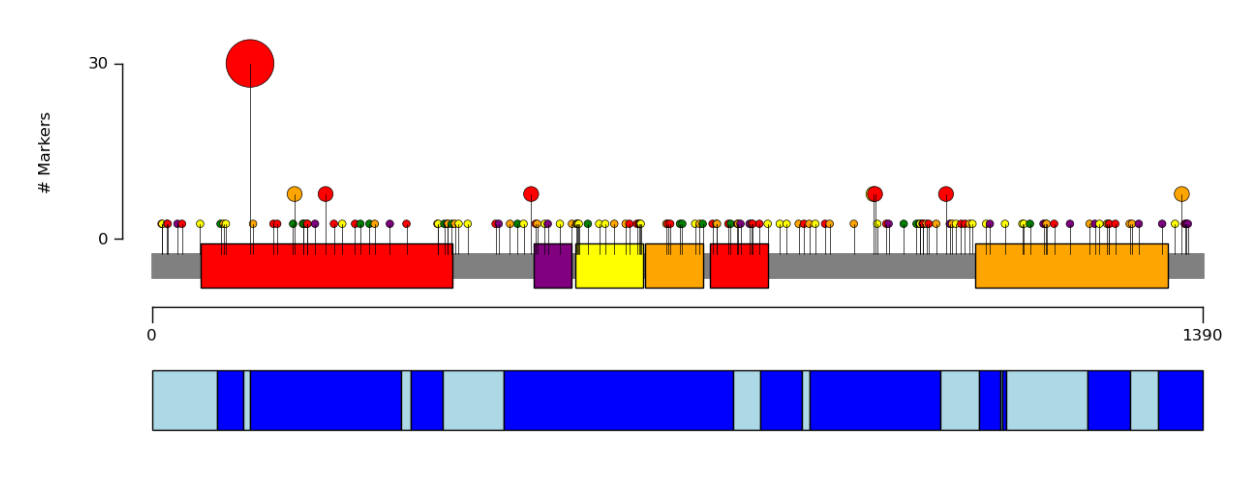

The plot consists of 2 tracks: transcript and protein. The transcript track consists of adjacent adjacent blue/light blue boxes. The protein track features gray background with an overlay of colored boxes. The variant locations are depicted using lollipop markers. We can tweak the lollipop color and the diameter to represent variant properties.

## Main figure

The figure should have a title. The title should include the transcript and protein accessions, and probably also the protein name:

In [26]:
tx_coordinates.identifier, protein_meta.protein_id, protein_meta.label

('NM_001032386.2', 'NP_001027558.1', 'Sulfite oxidase, mitochondrial')

## Transcript track

The transcript track consists of adjacent boxes that represent CDS regions only. We do *not* plot UTRs or introns.

In the context of *SUOX*, the track should include 3 boxes with widths that are proportionate to CDS region lengths:

In [27]:
widths = [len(cds) for cds in tx_coordinates.get_cds_regions()]
widths

[50, 178, 1410]

As an addition to the existing track, we should include CDS region number, unless the box width is insufficient to accommodate the number. We should use 1-based numbering to make this user friendly. 

So, `1`, `2`, `3` in this case.

That's it for the transcript track.

## Protein track

Protein track is somwhat more elaborate.

The track has grey region that spans the entire protein sequence. In our case, it corresponds to `545` aminoacids. 

Note, due to the aminoacid length, the coordinates of the grey region span $[0, 545)$. Any feature that extends beyond these coordinates is a bug. It should generally not happen, but if it does, it is a hard error, you must raise an exception with enough context to allow the user to fix the input, and abort the drawing.

In [28]:
tx_coordinates.get_codon_count()

545

We must ensure that the grey region is perfectly aligned with the transcript track.

The grey region is overlaid with boxes that correspond to protein features. As stated above, each feature has the coordinates with respect to the entire protein (gray region):

In [29]:
for pf in protein_meta.protein_features:
    print(pf.info.region)

Region(start=82, end=161)
Region(start=165, end=174)
Region(start=175, end=401)
Region(start=402, end=538)


So, in this example, we need to draw 4 boxes located at the corresponding regions. I believe that the boxes will never overlap, they should be, at most, adjacent.

> I recommend adding a check that the features do not overlap and raising an exception if they do.

We need to inform the user about the feature type (`genophenocorr.model.FeatureType`). One way of doing this is to use different colors but feel free to do whatever you like:

In [30]:
for pf in protein_meta.protein_features:
    print(pf.feature_type)

FeatureType.DOMAIN
FeatureType.REGION
FeatureType.REGION
FeatureType.REGION


We should annotate the boxes with the feature name if the box size permits:

In [31]:
for pf in protein_meta.protein_features:
    print(pf.info.name)

Cytochrome b5 heme-binding
Hinge
Moco domain
Homodimerization


That's it for the protein representation.

## Variants

We need to show the location and attributes of variants found in the patient cohort. In principle, the variants could be drawn on either or both of the tracks. However, let's focus on protein track for now.

First, a word of caution. Always think of a variant as of a *region* and not a *point*. After all, each point is a region with length `1`, right? Unlike protein features or CDS regions, the variant regions can overlap. Most of the time we will work with short variants and we can make some simplifications, but we may need to tweak this in future, so please keep this in mind.

Getting the protein regions affected by the variants is a bit convoluted. Remember, the variant has information with respect to each transcript of the gene. In case of *SUOX*, the alternative splicing can produce x transcripts. So, we retrieve the annotation corresponding to the transcript of choice and then access the protein region. I show how to do this for the first 5 variants for simplicity:

In [32]:
tx_anns = []
for i, v in enumerate(variants):
    if i == 5:
        break
    tx_ann = None
    for ann in v.tx_annotations:
        if ann.transcript_id == tx_id:
            tx_ann = ann
            break
    if tx_ann is None:
        raise ValueError(f'The transcript annotation for {tx_id} was not found!')
    else:
        tx_anns.append(tx_ann)

for ann in tx_anns:
    print(ann.protein_effect_location)

Region(start=375, end=376)
Region(start=216, end=217)
Region(start=361, end=362)
Region(start=505, end=507)
Region(start=294, end=295)


We got the variant regions. In four out of five casese, the variant affects one aminoacid. However, the second variant spans *two* aminoacids!

The question is what is the best way to draw variants as regions. I am not sure this can be done easily with lollipops. However, to keep things simple, we can draw the lollipop at the start coordinate.

Next, we need to encode the variant effects. Each variant can have `1..m` effects on a transcript. The effects are members of the `genophenocorr.model.VariantEffect` enum. 

For simplicity, let's just choose the first effect and we can update this strategy later:

In [33]:
for ann in tx_anns:
    print(ann.variant_effects[0])

missense_variant
missense_variant
missense_variant
frameshift_variant
missense_variant


Last, some variants occurr more frequently than the others. In general, the variant count should be in range $[1, n)$ where $n$ is the number of patients in the cohort. We should be able to communicate the variant frequency to the users.

In your figure, you do this using the lollipop color. I think it's OK.

So, these are the main requirements.

## Nice to have

There are several things that would be nice to have, depending on how difficult their implementation would be. I list a few in arbitrary order (no precedence).

### Variant overlap

Currently, the lollipops overlap and it may be hard to see all the data.

Ideally, the lollipops should not overlap. However, I am not sure how easy it would be to implement a layout algorithm to ensure there is no overlap.

### View point

Some medically releveant genes are very large. For instance, the protein *dystrophin* encoded by [*DMD*](https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:2928) gene consists of 79 exons. The CDS includes ~11 thousand nucleotides. Dystrophin is, however, medically relevant and showing variants on such a large gene can bring up some issues.

It could be helpful to be able to limit the picture on some part of the gene. Say, only the protein region $[a,b)$ or the exons $[a,b)$, ...

### Popup on hover

Is it possible to add information that shows on mouse cursor hover? We could show lots of useful info at many places. However, I am not sure how easy this would be. We intend to provide the figure through Jupyter, so the popup functionality would have to work there.

### Scales

Right now the plot includes two scales - `0 - 1390` and `# Markers`. I think the aminoacid scale is useful, and we should add a similar scale to the transcript plot to represent nulceotides, if possible. 

`# Markers` is great as well. It should probably start at `1`, it would be great to include a bunch of major ticks, and perhaps also horizontal grid lines? That would be SUPER cool.. :)

### API

Right now we make show certain things on the figure. For instance, we color the lollipop based on variant effect. However, I can imagine abstracting the coloring scheme away such that we can color the lollipop in arbitrary fashion (e.g. missense = red, others = blue). The same applies to other variant attributes, such as lollipop size and height.

It would be great if the coloring scheme (and others) would be adjustable. This would allow us to provide a bunch of useful presets but also letting the users to do whatevery they wish.


This is all I can think of right now.

---

To conclude, the figure is really amazing! I hope this is useful and let's stay in touch!